# IMPORT RELEVANT LIBRARIES

In [74]:


import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

## PREPARE DATA

### IMPORT

In [75]:
def wrangle(filename):
    # Load data
    df = pd.read_csv(filename)
    
    # Drop column Timestamp column
    df = df.drop(columns=["Timestamp"])
    
    # Create Binary Target column
    df['First Class'] = (df['Class'] == 'First class (4.5 -5.0)').astype(int)
    
    # Drop original Class column to avoid data leakage.
    df = df.drop(columns=["Class"])

    #Convert "other activities" column to an int
    df['Other activities'] = (df['Other activities'] == 'Yes').astype(int)
    
    return df

In [76]:
df = wrangle("/kaggle/input/student-performance-analysis-dataset/Student Performance Analysis_073758.csv")


### INSPECT DATAFRAME

In [77]:

# Check the shape and head of the DataFrame
print(df.shape)
df.head()

(215, 10)


,Level,Department,Courses written,Total unit load,Attendance,Study length,Exam preparation,Other activities,Time in activities,First Class
0,3rd Year,Biochemistry,57,123,4,3,3,1,3,0
1,1st Year,Computer science,18,39,5,5,3,1,5,1
2,2nd Year,Statistics,30,60,2,3,1,1,5,0
3,1st Year,Computer science,18,39,4,4,5,0,1,1
4,3rd Year,Biochemistry,57,123,2,3,2,1,3,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Level               215 non-null    object
 1   Department          215 non-null    object
 2   Courses written     215 non-null    int64 
 3   Total unit load     215 non-null    int64 
 4   Attendance          215 non-null    int64 
 5   Study length        215 non-null    int64 
 6   Exam preparation    215 non-null    int64 
 7   Other activities    215 non-null    int64 
 8   Time in activities  215 non-null    int64 
 9   First Class         215 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.9+ KB


## EXPLORE

CLASS DISTRIBUTION.

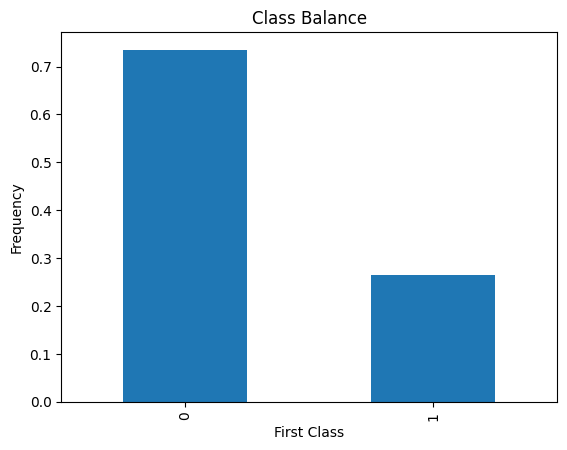

In [79]:
# Plot class balance
df["First Class"].value_counts(normalize=True).plot(
    kind="bar", xlabel="First Class", ylabel="Frequency", title="Class Balance"
);

In [80]:
majority_class_prop, minority_class_prop = df["First Class"].value_counts(normalize = True) 
print("Majority class proportion: ", majority_class_prop, "\nMinority class proportion: ", minority_class_prop)

Majority class proportion:  0.7348837209302326 
Minority class proportion:  0.2651162790697674


Conclusion: From the above visualization and proportion distribution ratio, it is seen that there is class imbalance in the target class and this could bias in model prediction towards the majority class, so we would be handling this using RandomOverSampler or Class weighting technique.

### SPLIT

In [81]:
features = ["Attendance", "Study length", "Exam preparation", "Other activities", "Time in activities"]
target = "First Class"

X = df[features]
y = df[target]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42

)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (172, 5)
y_train shape: (172,)
X_test shape: (43, 5)
y_test shape: (43,)


### RANDOM OVERSAMPLING

In [83]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(256, 5)


,Attendance,Study length,Exam preparation,Other activities,Time in activities
0,4,3,3,1,3
1,4,3,4,0,1
2,5,4,5,1,2
3,5,4,4,1,3
4,3,3,3,1,3


## BUILD MODELS

BASELINE MODEL

In [84]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy: ", round((acc_baseline * 100), 1))

Baseline Accuracy:  74.4


LOGISTIC REGRESSION

In [85]:
#Build Logistic Regression Model
model_lr = LogisticRegression(max_iter=1000)

#Fit model to training data
model_lr.fit(X_train_over, y_train_over)

LogisticRegression(max_iter=1000)

In [86]:
# Evaluate  logistic regression Model
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.63
Test Accuracy: 0.56


DECISION TREE

In [87]:
#Build Decision Tree Model
model_dt =  DecisionTreeClassifier(max_depth = 6, random_state=42)

# Fit model to training data
model_dt.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [88]:
# Evaluate  Decision Tree Model
acc_train = accuracy_score(y_train, model_dt.predict(X_train))
acc_test = model_dt.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.78
Test Accuracy: 0.49


RANDOM FOREST CLASSIFIER

In [89]:
#Build Random Forest Model
clf = RandomForestClassifier(random_state=42)

params = {
    "n_estimators": range(25, 100, 25),  
    "max_depth": range(10, 50, 10)       
}

model_rf = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model_rf

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [90]:
# Train  random forest model
model_rf.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [91]:
# Evaluate  Random Forest Model
acc_train = accuracy_score(y_train, model_rf.predict(X_train))
acc_test = model_rf.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))


Training Accuracy: 0.85
Test Accuracy: 0.56


GRADIENT BOOSTING CLASSIFIER

In [92]:
#Build Random Forest Model
clf =  GradientBoostingClassifier()

params = {
    "n_estimators": range(20, 31, 5),  
    "max_depth": range(2, 5)       
}

model_GB = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model_GB

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(20, 31, 5)},
             verbose=1)

In [93]:
#Train Gradient Boosting Model 
model_GB.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(20, 31, 5)},
             verbose=1)

In [94]:
# Evaluate  Gradient Boosting Model
acc_train = accuracy_score(y_train, model_GB.predict(X_train))
acc_test = model_GB.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.77
Test Accuracy: 0.6


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bfbec3ea-6127-4398-910c-7d332d17eb76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>